In [ ]:
import os
import numpy as np
from tqdm import tqdm
import cv2
import importlib
import dbops_updated as dbops

from facelib import FaceRecognizer, FaceDetector
from facelib import get_config, load_facebank, update_facebank

from matplotlib import pyplot as plt
%matplotlib inline

from IPython.display import display
from PIL import Image  # For loading images

import glob

import torch
import torchvision.transforms.functional as F

In [14]:
importlib.reload(dbops)  # Reload the module from source

<module 'dbops_updated' from '/home/u1541638/Projects/Data-Mining-Spring-2025-Project/dbops_updated.py'>

# Load Movie

In [15]:
TEST_MOVIE = "tt0075314"
CLUSTER_DIR = "/scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output"

In [16]:
movie_ref = dbops.Movie(TEST_MOVIE)
title = movie_ref.get_title()
cluster_dir_movie = os.path.join(CLUSTER_DIR, title)
print(f"Movie title: {title}")
print(f"Cluster directory: {cluster_dir_movie}")

Movie title: Taxi Driver
Cluster directory: /scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver


# Load clusters from Cluster directory

In [17]:
clusters = {}
for p in glob.glob(cluster_dir_movie + "/*"):
    cluster_name = p.split("/")[-1]
    num_files = len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p, f))])
    print(f"Cluster: {cluster_name}, Number of files: {num_files}")
    if num_files > 0:
        clusters[(p.split("/")[-1])] = p

print(f"Clusters found: {clusters}")

Cluster: tt0075314_cluster_4, Number of files: 20
Cluster: tt0075314_cluster_3, Number of files: 20
Cluster: tt0075314_cluster_7, Number of files: 20
Cluster: tt0075314_cluster_0, Number of files: 20
Cluster: tt0075314_cluster_8, Number of files: 20
Cluster: tt0075314_cluster_1, Number of files: 20
Cluster: tt0075314_cluster_6, Number of files: 20
Clusters found: {'tt0075314_cluster_4': '/scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver/tt0075314_cluster_4', 'tt0075314_cluster_3': '/scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver/tt0075314_cluster_3', 'tt0075314_cluster_7': '/scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver/tt0075314_cluster_7', 'tt0075314_cluster_0': '/scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver/tt0075314_cluster_0', 'tt0075314_cluster_8': '/scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver/tt007

# Add the cluster directory to the face bank

In [18]:
from pathlib import Path

def add_from_folder(folder_path='./', person_name='unknow'):
    
    print('only a face in each image and all image from the same person')
    dir_path = Path(folder_path)
    if not dir_path.is_dir():
        exit('dir does not exists !!')

    # create facebank folder if is not exists
    save_path = Path(os.path.dirname(os.path.realpath('/home/u1541638/.local/lib/python3.9/site-packages/facelib/InsightFace/models')), 'models/data/facebank')
    print(save_path)
    if not save_path.exists():
        save_path.mkdir()


    save_path = Path(f'{save_path}/{person_name}')
    if not save_path.exists():
        save_path.mkdir()
    print('loading ...')
    # init detector
    detector = FaceDetector(name='resnet')

    counter = 0
    for img_path in dir_path.iterdir():
        img = cv2.imread(str(img_path))
        if img is None:
            raise Exception('this image has a problem: ', img_path)
        face = detector.detect_align(img)[0].cpu().numpy()
        if len(face.shape) > 1:
            save_name = f'{save_path}/{dir_path.name}_{counter}.jpg'
            cv2.imwrite(save_name, face[0])
            counter += 1
        else:
            print(img_path, 'in this image did not detect any face')
    print('images saved in this path: ', save_path)
            


In [19]:
for cluster_name, cluster_path in clusters.items():
    print(f"Cluster name: {cluster_name}")
    print(f"Cluster path: {cluster_path}")
    add_from_folder(cluster_path, cluster_name)


Cluster name: tt0075314_cluster_4
Cluster path: /scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver/tt0075314_cluster_4
only a face in each image and all image from the same person
/home/u1541638/.local/lib/python3.9/site-packages/facelib/InsightFace/models/data/facebank
loading ...
images saved in this path:  /home/u1541638/.local/lib/python3.9/site-packages/facelib/InsightFace/models/data/facebank/tt0075314_cluster_4
Cluster name: tt0075314_cluster_3
Cluster path: /scratch/u1541638/Data-Mining-Spring-2025-Project/images/cluster_output/Taxi Driver/tt0075314_cluster_3
only a face in each image and all image from the same person
/home/u1541638/.local/lib/python3.9/site-packages/facelib/InsightFace/models/data/facebank
loading ...
images saved in this path:  /home/u1541638/.local/lib/python3.9/site-packages/facelib/InsightFace/models/data/facebank/tt0075314_cluster_3
Cluster name: tt0075314_cluster_7
Cluster path: /scratch/u1541638/Data-Mining-Spring-2025-

# Update face bank with added clusters

In [20]:
conf = get_config()
# conf.use_mobilenet=False # if you want to use the bigger model
detector = FaceDetector(device=conf.device, name='resnet')
face_rec = FaceRecognizer(conf)

In [21]:
# set True when you add someone new to the facebank
update_facebank_for_add_new_person = True
if update_facebank_for_add_new_person:
    targets, names = update_facebank(conf, face_rec.model, detector)
else:
    targets, names = load_facebank(conf)


from FaceRecognizer: facebank updated


# Sample the movie frames and display the sampled faces and facial recognition labels

In [22]:
def to_pil_image(aligned_face):
    """
    Convert a normalized aligned face (float32, BGR, [0,1]) to a PIL RGB image.
    """
    # Step 1: Multiply by 255 to get pixel values in [0, 255]
    img_uint8 = (aligned_face * 255).clip(0, 255).astype(np.uint8)

    # Step 2: Convert BGR (OpenCV format) to RGB (PIL format)
    img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB)

    # Step 3: Convert to PIL Image
    return Image.fromarray(img_rgb)


  0%|          | 0/2387 [00:00<?, ?it/s]

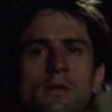

  1%|          | 14/2387 [00:00<00:33, 70.26it/s]

tensor([3]) tensor([0.3994], device='cuda:0')
tt0075314_cluster_7


  2%|▏         | 57/2387 [00:00<00:29, 77.83it/s]

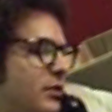

  3%|▎         | 73/2387 [00:00<00:30, 76.49it/s]

tensor([5]) tensor([0.8944], device='cuda:0')
tt0075314_cluster_8


  5%|▍         | 116/2387 [00:01<00:27, 81.87it/s]

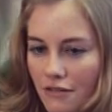

  6%|▌         | 133/2387 [00:01<00:29, 77.47it/s]

tensor([1]) tensor([0.4939], device='cuda:0')
tt0075314_cluster_4


  6%|▋         | 150/2387 [00:01<00:28, 78.23it/s]

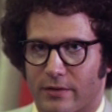

  7%|▋         | 166/2387 [00:02<00:29, 76.40it/s]

tensor([5]) tensor([0.7443], device='cuda:0')
tt0075314_cluster_8


  7%|▋         | 174/2387 [00:02<00:29, 75.24it/s]

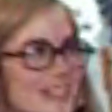

  8%|▊         | 190/2387 [00:02<00:29, 74.76it/s]

tensor([1]) tensor([1.0552], device='cuda:0')
tt0075314_cluster_4


 12%|█▏        | 294/2387 [00:03<00:25, 81.37it/s]

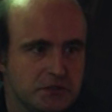

 13%|█▎        | 312/2387 [00:04<00:25, 79.86it/s]

tensor([0]) tensor([0.9301], device='cuda:0')
Unknown


 14%|█▍        | 330/2387 [00:04<00:25, 80.60it/s]

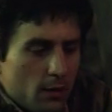

 14%|█▍        | 339/2387 [00:04<00:26, 78.23it/s]

tensor([3]) tensor([1.1472], device='cuda:0')
tt0075314_cluster_7


 15%|█▍        | 356/2387 [00:04<00:25, 80.04it/s]

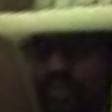

 16%|█▌        | 374/2387 [00:04<00:26, 77.36it/s]

tensor([2]) tensor([1.3429], device='cuda:0')
tt0075314_cluster_3


 17%|█▋        | 415/2387 [00:05<00:24, 79.01it/s]

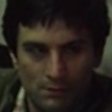

 18%|█▊        | 431/2387 [00:05<00:25, 77.74it/s]

tensor([3]) tensor([0.6881], device='cuda:0')
tt0075314_cluster_7


 19%|█▉        | 449/2387 [00:05<00:24, 79.08it/s]

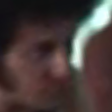

 20%|█▉        | 466/2387 [00:06<00:25, 76.07it/s]

tensor([5]) tensor([1.3294], device='cuda:0')
tt0075314_cluster_8


 20%|█▉        | 475/2387 [00:06<00:24, 77.67it/s]

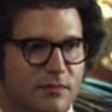

 21%|██        | 492/2387 [00:06<00:23, 79.03it/s]

tensor([5]) tensor([0.6179], device='cuda:0')
tt0075314_cluster_8


 21%|██▏       | 510/2387 [00:06<00:23, 79.93it/s]

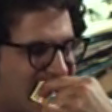

 22%|██▏       | 527/2387 [00:06<00:23, 77.60it/s]

tensor([5]) tensor([1.0418], device='cuda:0')
tt0075314_cluster_8


 22%|██▏       | 536/2387 [00:06<00:23, 78.67it/s]

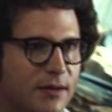

 23%|██▎       | 552/2387 [00:07<00:23, 76.85it/s]

tensor([5]) tensor([0.6673], device='cuda:0')
tt0075314_cluster_8


 24%|██▍       | 569/2387 [00:07<00:23, 77.89it/s]

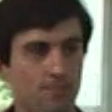

 25%|██▍       | 585/2387 [00:07<00:23, 76.30it/s]

tensor([3]) tensor([1.2100], device='cuda:0')
tt0075314_cluster_7


 25%|██▍       | 594/2387 [00:07<00:22, 78.66it/s]

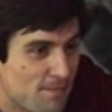

 26%|██▌       | 610/2387 [00:07<00:23, 76.30it/s]

tensor([3]) tensor([1.1808], device='cuda:0')
tt0075314_cluster_7


 26%|██▋       | 628/2387 [00:08<00:22, 79.40it/s]

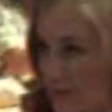

 27%|██▋       | 645/2387 [00:08<00:22, 76.82it/s]

tensor([1]) tensor([0.9331], device='cuda:0')
tt0075314_cluster_4


 27%|██▋       | 654/2387 [00:08<00:21, 79.31it/s]

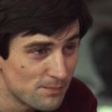

 28%|██▊       | 671/2387 [00:08<00:22, 77.89it/s]

tensor([3]) tensor([1.1250], device='cuda:0')
tt0075314_cluster_7


 29%|██▉       | 687/2387 [00:08<00:21, 77.62it/s]

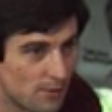

 29%|██▉       | 704/2387 [00:09<00:21, 79.24it/s]

tensor([3]) tensor([1.1129], device='cuda:0')
tt0075314_cluster_7


 30%|██▉       | 712/2387 [00:09<00:21, 78.54it/s]

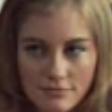

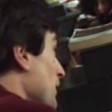

 31%|███       | 730/2387 [00:09<00:21, 78.87it/s]

tensor([1, 3]) tensor([0.5749, 1.2858], device='cuda:0')
['tt0075314_cluster_4' 'tt0075314_cluster_7']


 31%|███▏      | 748/2387 [00:09<00:20, 81.49it/s]

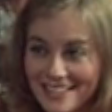

 32%|███▏      | 766/2387 [00:09<00:20, 78.03it/s]

tensor([1]) tensor([0.7724], device='cuda:0')
tt0075314_cluster_4


 34%|███▍      | 810/2387 [00:10<00:19, 81.28it/s]

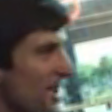

 34%|███▍      | 819/2387 [00:10<00:20, 77.70it/s]

tensor([3]) tensor([1.1998], device='cuda:0')
tt0075314_cluster_7


 35%|███▍      | 835/2387 [00:10<00:20, 77.39it/s]

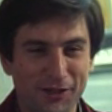

 36%|███▌      | 851/2387 [00:10<00:20, 76.21it/s]

tensor([3]) tensor([0.9744], device='cuda:0')
tt0075314_cluster_7


 36%|███▋      | 868/2387 [00:11<00:19, 77.34it/s]

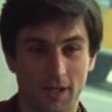

 37%|███▋      | 884/2387 [00:11<00:19, 75.83it/s]

tensor([3]) tensor([0.9638], device='cuda:0')
tt0075314_cluster_7


 37%|███▋      | 892/2387 [00:11<00:19, 75.25it/s]

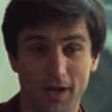

 38%|███▊      | 910/2387 [00:11<00:18, 77.90it/s]

tensor([3]) tensor([0.8704], device='cuda:0')
tt0075314_cluster_7


 39%|███▉      | 928/2387 [00:11<00:18, 80.43it/s]

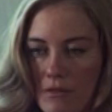

 40%|███▉      | 946/2387 [00:12<00:18, 78.42it/s]

tensor([1]) tensor([0.5937], device='cuda:0')
tt0075314_cluster_4


 40%|████      | 955/2387 [00:12<00:17, 80.94it/s]

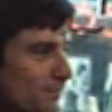

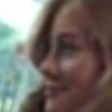

 41%|████      | 972/2387 [00:12<00:17, 78.67it/s]

tensor([3, 1]) tensor([1.1438, 0.9625], device='cuda:0')
['tt0075314_cluster_7' 'tt0075314_cluster_4']


 41%|████▏     | 990/2387 [00:12<00:16, 82.85it/s]

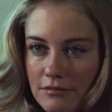

 42%|████▏     | 999/2387 [00:12<00:17, 78.80it/s]

tensor([1]) tensor([0.5721], device='cuda:0')
tt0075314_cluster_4


 44%|████▎     | 1042/2387 [00:13<00:18, 74.43it/s]

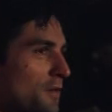

 44%|████▍     | 1061/2387 [00:13<00:16, 79.11it/s]

tensor([3]) tensor([0.8975], device='cuda:0')
tt0075314_cluster_7


 45%|████▌     | 1079/2387 [00:13<00:16, 80.46it/s]

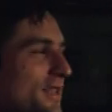

 46%|████▌     | 1097/2387 [00:14<00:16, 80.27it/s]

tensor([3]) tensor([0.9053], device='cuda:0')
tt0075314_cluster_7


 46%|████▋     | 1106/2387 [00:14<00:16, 79.87it/s]

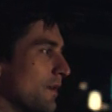

 47%|████▋     | 1124/2387 [00:14<00:15, 79.94it/s]

tensor([3]) tensor([0.8758], device='cuda:0')
tt0075314_cluster_7


 47%|████▋     | 1133/2387 [00:14<00:15, 80.13it/s]

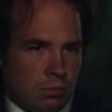

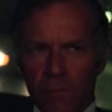

 48%|████▊     | 1151/2387 [00:14<00:15, 78.90it/s]

tensor([0, 6]) tensor([1.2513, 0.4861], device='cuda:0')
['Unknown' 'tt0075314_cluster_1']


 49%|████▉     | 1168/2387 [00:14<00:15, 80.15it/s]

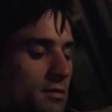

 50%|████▉     | 1186/2387 [00:15<00:15, 79.75it/s]

tensor([3]) tensor([0.8206], device='cuda:0')
tt0075314_cluster_7


 54%|█████▎    | 1283/2387 [00:16<00:12, 86.34it/s]

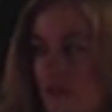

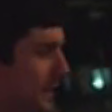

 54%|█████▍    | 1300/2387 [00:16<00:14, 76.90it/s]

tensor([1, 3]) tensor([0.9631, 1.0936], device='cuda:0')
['tt0075314_cluster_4' 'tt0075314_cluster_7']


 57%|█████▋    | 1372/2387 [00:17<00:12, 83.07it/s]

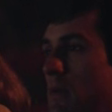

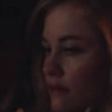

 58%|█████▊    | 1389/2387 [00:17<00:12, 78.28it/s]

tensor([3, 1]) tensor([0.8278, 0.6382], device='cuda:0')
['tt0075314_cluster_7' 'tt0075314_cluster_4']


 59%|█████▉    | 1407/2387 [00:17<00:12, 80.70it/s]

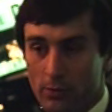

 60%|█████▉    | 1425/2387 [00:18<00:11, 80.84it/s]

tensor([3]) tensor([0.9602], device='cuda:0')
tt0075314_cluster_7


 62%|██████▏   | 1470/2387 [00:18<00:11, 78.10it/s]

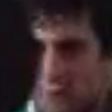

 62%|██████▏   | 1487/2387 [00:18<00:11, 75.98it/s]

tensor([3]) tensor([1.0285], device='cuda:0')
tt0075314_cluster_7


 68%|██████▊   | 1618/2387 [00:20<00:09, 82.61it/s]

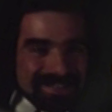

 69%|██████▊   | 1636/2387 [00:20<00:09, 80.07it/s]

tensor([2]) tensor([0.5716], device='cuda:0')
tt0075314_cluster_3


 71%|███████▏  | 1704/2387 [00:21<00:08, 77.73it/s]

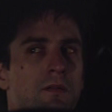

 72%|███████▏  | 1720/2387 [00:21<00:08, 77.39it/s]

tensor([3]) tensor([0.6328], device='cuda:0')
tt0075314_cluster_7


 73%|███████▎  | 1737/2387 [00:22<00:08, 78.14it/s]

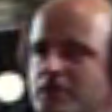

 73%|███████▎  | 1753/2387 [00:22<00:08, 74.90it/s]

tensor([0]) tensor([0.9044], device='cuda:0')
Unknown


 74%|███████▍  | 1769/2387 [00:22<00:08, 73.34it/s]

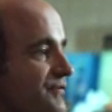

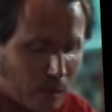

 75%|███████▍  | 1785/2387 [00:22<00:08, 72.50it/s]

tensor([0, 4]) tensor([0.9804, 1.1152], device='cuda:0')
['Unknown' 'tt0075314_cluster_0']


 75%|███████▌  | 1793/2387 [00:22<00:08, 74.15it/s]

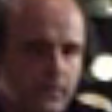

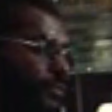

 76%|███████▌  | 1810/2387 [00:23<00:07, 76.41it/s]

tensor([0, 2]) tensor([0.7990, 1.2796], device='cuda:0')
['Unknown' 'tt0075314_cluster_3']


 76%|███████▋  | 1826/2387 [00:23<00:07, 77.50it/s]

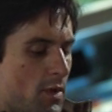

 77%|███████▋  | 1843/2387 [00:23<00:06, 78.84it/s]

tensor([3]) tensor([1.0230], device='cuda:0')
tt0075314_cluster_7


 79%|███████▉  | 1885/2387 [00:24<00:06, 76.29it/s]

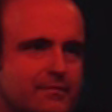

 80%|███████▉  | 1903/2387 [00:24<00:06, 80.14it/s]

tensor([0]) tensor([0.7591], device='cuda:0')
Unknown


 80%|████████  | 1912/2387 [00:24<00:05, 79.36it/s]

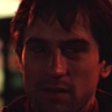

 81%|████████  | 1932/2387 [00:24<00:05, 83.44it/s]

tensor([3]) tensor([0.7446], device='cuda:0')
tt0075314_cluster_7


 83%|████████▎ | 1976/2387 [00:25<00:05, 77.62it/s]

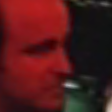

 83%|████████▎ | 1992/2387 [00:25<00:05, 74.67it/s]

tensor([0]) tensor([0.6725], device='cuda:0')
Unknown


 84%|████████▍ | 2009/2387 [00:25<00:04, 77.57it/s]

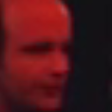

 85%|████████▍ | 2025/2387 [00:25<00:04, 77.08it/s]

tensor([0]) tensor([0.6938], device='cuda:0')
Unknown


 89%|████████▉ | 2126/2387 [00:27<00:03, 76.66it/s]

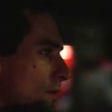

 90%|████████▉ | 2142/2387 [00:27<00:03, 73.12it/s]

tensor([3]) tensor([0.9054], device='cuda:0')
tt0075314_cluster_7


 90%|█████████ | 2158/2387 [00:27<00:03, 73.89it/s]

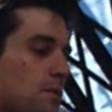

 91%|█████████ | 2174/2387 [00:27<00:02, 74.43it/s]

tensor([3]) tensor([0.8683], device='cuda:0')
tt0075314_cluster_7


 98%|█████████▊| 2333/2387 [00:29<00:00, 77.30it/s]

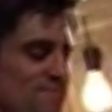

 98%|█████████▊| 2349/2387 [00:30<00:00, 75.69it/s]

tensor([3]) tensor([1.0533], device='cuda:0')
tt0075314_cluster_7


 99%|█████████▉| 2365/2387 [00:30<00:00, 77.35it/s]

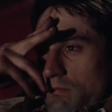

100%|██████████| 2387/2387 [00:30<00:00, 77.98it/s]

tensor([3]) tensor([0.7313], device='cuda:0')
tt0075314_cluster_7


In [ ]:
all_frames = movie_ref.iterate_frames()
i = -1

for frame in tqdm(all_frames):
    faces = frame.iterate_faces()
    i += 1
    if i % 30 != 0:
        continue
    face_tensors = []
    for f in faces:
        img = f.get_face_image_aligned()

        arr = np.array(img) # [H, W, C]
        tensor = torch.from_numpy(arr).float() # [H, W, C]
        face_tensors.append(tensor)
        
        # Convert to PIL Image and display
        pil_image = F.to_pil_image(arr)
        display(pil_image)


    if not face_tensors:
        continue

    faces_batch = torch.stack(face_tensors)  # [N, 112, 112, 3]

    results, score = face_rec.infer(faces_batch, targets)
    person = names[results.cpu()]
    print(results.cpu(), score)
    print(person)
    
    # if i == 200:
    #     break